In [1]:
#https://www.researchgate.net/post/Multiclass-classification-micro-weighted-recall-equals-accuracy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package import StudentModel, TeacherModel
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time


###### SK LEARN METHOD ######
# def compare_performance_metrics(teacher, student, dataloader):
#     teacher.eval()
#     student.eval()
    
#     all_labels = []
#     all_teacher_preds = []
#     all_student_preds = []

#     for inputs, labels in dataloader:
#         with torch.no_grad():
#             teacher_outputs = teacher(inputs.to(device))
#             student_outputs = student(inputs.to(device))
#         all_labels.append(labels.cpu().numpy())
#         all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
#         all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

#     all_labels = np.concatenate(all_labels)
#     all_teacher_preds = np.concatenate(all_teacher_preds)
#     all_student_preds = np.concatenate(all_student_preds)
    
    # metrics = {
    #     'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
    #     'precision': (precision_score(all_labels, all_teacher_preds, average='weighted'), precision_score(all_labels, all_student_preds, average='weighted')),
    #     'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
    #     'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    # }

#     return metrics

# def compare_performance_metrics(teacher, student, dataloader):
#     teacher.eval()
#     student.eval()
    
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
#     all_labels = []
#     all_teacher_preds = []
#     all_student_preds = []

#     for inputs, labels in dataloader:
#         with torch.no_grad():
#             teacher_outputs = teacher(inputs.to(device))
#             student_outputs = student(inputs.to(device))
#         all_labels.append(labels.cpu().numpy())
#         all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
#         all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

#     all_labels = np.concatenate(all_labels)
#     all_teacher_preds = np.concatenate(all_teacher_preds)
#     all_student_preds = np.concatenate(all_student_preds)
    
#     metrics_dict = {
#         'accuracy': (
#             accuracy_score(all_labels, all_teacher_preds),
#             accuracy_score(all_labels, all_student_preds)
#         ),
#         'precision': (
#             precision_score(all_labels, all_teacher_preds, average='macro'),
#             precision_score(all_labels, all_student_preds, average='macro')
#         ),
#         'recall': (
#             recall_score(all_labels, all_teacher_preds, average='macro'),
#             recall_score(all_labels, all_student_preds, average='macro')
#         ),
#         'f1': (
#             f1_score(all_labels, all_teacher_preds, average='macro'),
#             f1_score(all_labels, all_student_preds, average='macro')
#         )
#     }
    
#     return metrics_dict


###### TORCH EVAL METHOD ######
def confusion_matrix(preds, labels, num_classes):
    conf_matrix = torch.zeros(num_classes, num_classes)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

def calculate_metrics(conf_matrix):
    TP = torch.diag(conf_matrix)
    FP = conf_matrix.sum(dim=1) - TP
    FN = conf_matrix.sum(dim=0) - TP

    # Macro-average
    precision_macro = (TP / (TP + FP + 1e-10)).mean()
    recall_macro = (TP / (TP + FN + 1e-10)).mean()
    f1_macro = 2 * (precision_macro * recall_macro) / (precision_macro + recall_macro + 1e-10)
    
    accuracy = TP.sum() / conf_matrix.sum()
    
    return {
        'accuracy': accuracy.item(),
        'precision': precision_macro.item(),
        'recall': recall_macro.item(),
        'f1': f1_macro.item()
    }

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    num_classes = len(dataloader.dataset.classes)
    teacher_conf_matrix = torch.zeros(num_classes, num_classes)
    student_conf_matrix = torch.zeros(num_classes, num_classes)
    
    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        _, teacher_preds = torch.max(teacher_outputs, dim=1)
        _, student_preds = torch.max(student_outputs, dim=1)
        teacher_conf_matrix += confusion_matrix(teacher_preds.cpu(), labels.cpu(), num_classes)
        student_conf_matrix += confusion_matrix(student_preds.cpu(), labels.cpu(), num_classes)
    
    teacher_metrics = calculate_metrics(teacher_conf_matrix)
    student_metrics = calculate_metrics(student_conf_matrix)
    
    metrics_dict = {
        'accuracy': (
            teacher_metrics['accuracy'],
            student_metrics['accuracy']
        ),
        'precision': (
            teacher_metrics['precision'],
            student_metrics['precision']
        ),
        'recall': (
            teacher_metrics['recall'],
            student_metrics['recall']
        ),
        'f1': (
            teacher_metrics['f1'],
            student_metrics['f1']
        )
    }
    
    return metrics_dict



def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [3]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 5
num_workers = 2
batch_size = 32
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# Load the CIFAR-100 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256, 256)),
    # transforms.Pad((112, 112, 112, 112), padding_mode=‘constant’, fill=0),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(256, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)


Files already downloaded and verified


In [4]:
# Instantiate the models
teacher_model = TeacherModel(in_features=64, num_classes=num_classes)
student_model = StudentModel(in_features=16, num_classes=num_classes)

# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Knowledge Distillation loss function
def knowledge_distillation_loss(student_outputs, teacher_outputs, temperature):
    kd_loss = F.kl_div(
        F.log_softmax(student_outputs / temperature, dim=1),
        F.softmax(teacher_outputs / temperature, dim=1),
        reduction='batchmean'
    ) * (temperature * temperature)
    return kd_loss

# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5):
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        scheduler.step()
    print("Finished Training Teacher")

# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = knowledge_distillation_loss(student_outputs, teacher_outputs, temperature)
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        scheduler.step()
    print("Finished Training Student")

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)

# Save the student model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights.pth')
torch.save(student_model, 'student_model.pth')
print('weights saved and exported')

  7%|████████▌                                                                                                                        | 103/1563 [00:06<01:24, 17.30it/s]

[1, 100] loss: 4.575


 13%|████████████████▊                                                                                                                | 203/1563 [00:12<01:17, 17.54it/s]

[1, 200] loss: 4.464


 19%|█████████████████████████                                                                                                        | 303/1563 [00:17<01:13, 17.24it/s]

[1, 300] loss: 4.400


 26%|█████████████████████████████████▎                                                                                               | 403/1563 [00:23<01:06, 17.51it/s]

[1, 400] loss: 4.302


 32%|█████████████████████████████████████████▌                                                                                       | 503/1563 [00:29<01:01, 17.17it/s]

[1, 500] loss: 4.253


 39%|█████████████████████████████████████████████████▊                                                                               | 603/1563 [00:35<00:55, 17.19it/s]

[1, 600] loss: 4.196


 45%|██████████████████████████████████████████████████████████                                                                       | 703/1563 [00:40<00:49, 17.37it/s]

[1, 700] loss: 4.157


 51%|██████████████████████████████████████████████████████████████████▎                                                              | 803/1563 [00:46<00:44, 17.05it/s]

[1, 800] loss: 4.078


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 903/1563 [00:52<00:38, 17.29it/s]

[1, 900] loss: 4.066


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1003/1563 [00:58<00:31, 17.88it/s]

[1, 1000] loss: 4.036


 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1103/1563 [01:03<00:27, 16.91it/s]

[1, 1100] loss: 3.974


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1203/1563 [01:09<00:20, 17.59it/s]

[1, 1200] loss: 3.929


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1303/1563 [01:15<00:15, 17.30it/s]

[1, 1300] loss: 3.907


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1403/1563 [01:21<00:09, 16.98it/s]

[1, 1400] loss: 3.914


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1503/1563 [01:26<00:03, 17.27it/s]

[1, 1500] loss: 3.855


  7%|████████▌                                                                                                                        | 103/1563 [00:06<01:27, 16.76it/s]

[2, 100] loss: 3.797


 13%|████████████████▊                                                                                                                | 203/1563 [00:12<01:21, 16.75it/s]

[2, 200] loss: 3.855


 19%|█████████████████████████                                                                                                        | 303/1563 [00:17<01:13, 17.17it/s]

[2, 300] loss: 3.782


 26%|█████████████████████████████████▎                                                                                               | 403/1563 [00:23<01:06, 17.46it/s]

[2, 400] loss: 3.814


 32%|█████████████████████████████████████████▌                                                                                       | 503/1563 [00:29<01:00, 17.66it/s]

[2, 500] loss: 3.818


 39%|█████████████████████████████████████████████████▊                                                                               | 603/1563 [00:35<00:56, 17.00it/s]

[2, 600] loss: 3.810


 45%|██████████████████████████████████████████████████████████                                                                       | 703/1563 [00:41<00:49, 17.48it/s]

[2, 700] loss: 3.747


 51%|██████████████████████████████████████████████████████████████████▎                                                              | 803/1563 [00:46<00:42, 17.74it/s]

[2, 800] loss: 3.778


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 903/1563 [00:52<00:38, 17.24it/s]

[2, 900] loss: 3.731


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1003/1563 [00:58<00:32, 17.27it/s]

[2, 1000] loss: 3.746


 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1103/1563 [01:04<00:27, 16.67it/s]

[2, 1100] loss: 3.752


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1203/1563 [01:10<00:21, 16.96it/s]

[2, 1200] loss: 3.726


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1303/1563 [01:15<00:15, 17.31it/s]

[2, 1300] loss: 3.697


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1403/1563 [01:21<00:09, 17.72it/s]

[2, 1400] loss: 3.722


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1503/1563 [01:27<00:03, 17.48it/s]

[2, 1500] loss: 3.667


  7%|████████▌                                                                                                                        | 103/1563 [00:06<01:25, 17.02it/s]

[3, 100] loss: 3.668


 13%|████████████████▊                                                                                                                | 203/1563 [00:11<01:19, 17.15it/s]

[3, 200] loss: 3.636


 19%|█████████████████████████                                                                                                        | 303/1563 [00:17<01:14, 16.90it/s]

[3, 300] loss: 3.645


 26%|█████████████████████████████████▎                                                                                               | 403/1563 [00:23<01:07, 17.21it/s]

[3, 400] loss: 3.636


 32%|█████████████████████████████████████████▌                                                                                       | 503/1563 [00:29<01:02, 16.98it/s]

[3, 500] loss: 3.653


 39%|█████████████████████████████████████████████████▊                                                                               | 603/1563 [00:35<00:53, 17.79it/s]

[3, 600] loss: 3.680


 45%|██████████████████████████████████████████████████████████                                                                       | 703/1563 [00:40<00:48, 17.60it/s]

[3, 700] loss: 3.611


 51%|██████████████████████████████████████████████████████████████████▎                                                              | 803/1563 [00:46<00:44, 17.19it/s]

[3, 800] loss: 3.618


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 903/1563 [00:52<00:38, 17.08it/s]

[3, 900] loss: 3.615


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1003/1563 [00:58<00:32, 17.44it/s]

[3, 1000] loss: 3.671


 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1103/1563 [01:04<00:25, 17.85it/s]

[3, 1100] loss: 3.622


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1203/1563 [01:09<00:21, 17.01it/s]

[3, 1200] loss: 3.638


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1303/1563 [01:15<00:14, 17.35it/s]

[3, 1300] loss: 3.606


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1403/1563 [01:21<00:09, 17.49it/s]

[3, 1400] loss: 3.526


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1503/1563 [01:27<00:03, 17.67it/s]

[3, 1500] loss: 3.577


  7%|████████▌                                                                                                                        | 103/1563 [00:06<01:26, 16.91it/s]

[4, 100] loss: 3.575


 13%|████████████████▊                                                                                                                | 203/1563 [00:11<01:18, 17.43it/s]

[4, 200] loss: 3.563


 19%|█████████████████████████                                                                                                        | 303/1563 [00:17<01:12, 17.47it/s]

[4, 300] loss: 3.553


 26%|█████████████████████████████████▎                                                                                               | 403/1563 [00:23<01:05, 17.63it/s]

[4, 400] loss: 3.576


 32%|█████████████████████████████████████████▌                                                                                       | 503/1563 [00:28<01:00, 17.39it/s]

[4, 500] loss: 3.528


 39%|█████████████████████████████████████████████████▊                                                                               | 603/1563 [00:34<00:54, 17.78it/s]

[4, 600] loss: 3.523


 45%|██████████████████████████████████████████████████████████                                                                       | 703/1563 [00:40<00:49, 17.47it/s]

[4, 700] loss: 3.565


 51%|██████████████████████████████████████████████████████████████████▎                                                              | 803/1563 [00:45<00:44, 17.09it/s]

[4, 800] loss: 3.548


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 903/1563 [00:51<00:38, 17.16it/s]

[4, 900] loss: 3.540


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1003/1563 [00:57<00:32, 17.06it/s]

[4, 1000] loss: 3.559


 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1103/1563 [01:03<00:26, 17.08it/s]

[4, 1100] loss: 3.496


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1203/1563 [01:09<00:20, 17.44it/s]

[4, 1200] loss: 3.564


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1303/1563 [01:14<00:14, 17.39it/s]

[4, 1300] loss: 3.518


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1403/1563 [01:20<00:09, 17.59it/s]

[4, 1400] loss: 3.575


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1503/1563 [01:26<00:03, 17.54it/s]

[4, 1500] loss: 3.508


  7%|████████▌                                                                                                                        | 103/1563 [00:06<01:24, 17.23it/s]

[5, 100] loss: 3.483


 13%|████████████████▊                                                                                                                | 203/1563 [00:11<01:17, 17.57it/s]

[5, 200] loss: 3.512


 19%|█████████████████████████                                                                                                        | 303/1563 [00:17<01:12, 17.34it/s]

[5, 300] loss: 3.509


 26%|█████████████████████████████████▎                                                                                               | 403/1563 [00:23<01:08, 16.97it/s]

[5, 400] loss: 3.508


 32%|█████████████████████████████████████████▌                                                                                       | 503/1563 [00:29<01:01, 17.26it/s]

[5, 500] loss: 3.486


 39%|█████████████████████████████████████████████████▊                                                                               | 603/1563 [00:34<00:56, 16.90it/s]

[5, 600] loss: 3.483


 45%|██████████████████████████████████████████████████████████                                                                       | 703/1563 [00:40<00:50, 17.05it/s]

[5, 700] loss: 3.482


 51%|██████████████████████████████████████████████████████████████████▎                                                              | 803/1563 [00:46<00:43, 17.31it/s]

[5, 800] loss: 3.492


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 903/1563 [00:52<00:36, 17.87it/s]

[5, 900] loss: 3.514


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1003/1563 [00:57<00:32, 17.27it/s]

[5, 1000] loss: 3.482


 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1103/1563 [01:03<00:26, 17.39it/s]

[5, 1100] loss: 3.488


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1203/1563 [01:09<00:20, 17.29it/s]

[5, 1200] loss: 3.476


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1303/1563 [01:15<00:14, 17.87it/s]

[5, 1300] loss: 3.441


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1403/1563 [01:20<00:08, 17.84it/s]

[5, 1400] loss: 3.491


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1503/1563 [01:26<00:03, 17.97it/s]

[5, 1500] loss: 3.456


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:30<00:00, 17.36it/s]


Finished Training Teacher


  7%|████████▌                                                                                                                        | 103/1563 [00:04<01:06, 22.02it/s]

[1, 100] loss: 1.941


 13%|████████████████▋                                                                                                                | 202/1563 [00:09<01:03, 21.37it/s]

[1, 200] loss: 1.900


 19%|█████████████████████████                                                                                                        | 304/1563 [00:14<01:00, 20.66it/s]

[1, 300] loss: 1.803


 26%|█████████████████████████████████▎                                                                                               | 403/1563 [00:18<00:54, 21.13it/s]

[1, 400] loss: 1.720


 32%|█████████████████████████████████████████▍                                                                                       | 502/1563 [00:23<00:45, 23.38it/s]

[1, 500] loss: 1.623


 39%|█████████████████████████████████████████████████▊                                                                               | 604/1563 [00:27<00:42, 22.52it/s]

[1, 600] loss: 1.504


 45%|██████████████████████████████████████████████████████████                                                                       | 703/1563 [00:32<00:37, 22.78it/s]

[1, 700] loss: 1.365


 51%|██████████████████████████████████████████████████████████████████▏                                                              | 802/1563 [00:36<00:37, 20.45it/s]

[1, 800] loss: 1.241


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 904/1563 [00:41<00:28, 22.96it/s]

[1, 900] loss: 1.144


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1003/1563 [00:46<00:25, 21.90it/s]

[1, 1000] loss: 1.048


 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1102/1563 [00:50<00:21, 21.28it/s]

[1, 1100] loss: 0.963


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1204/1563 [00:55<00:16, 22.25it/s]

[1, 1200] loss: 0.908


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1303/1563 [00:59<00:11, 21.88it/s]

[1, 1300] loss: 0.849


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1402/1563 [01:04<00:07, 20.47it/s]

[1, 1400] loss: 0.834


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1504/1563 [01:08<00:02, 20.83it/s]

[1, 1500] loss: 0.798


  7%|████████▌                                                                                                                        | 103/1563 [00:04<01:09, 21.10it/s]

[2, 100] loss: 0.753


 13%|████████████████▋                                                                                                                | 202/1563 [00:09<00:59, 22.85it/s]

[2, 200] loss: 0.719


 19%|█████████████████████████                                                                                                        | 304/1563 [00:13<00:59, 21.11it/s]

[2, 300] loss: 0.699


 26%|█████████████████████████████████▎                                                                                               | 403/1563 [00:18<00:54, 21.41it/s]

[2, 400] loss: 0.679


 32%|█████████████████████████████████████████▍                                                                                       | 502/1563 [00:23<00:50, 20.84it/s]

[2, 500] loss: 0.656


 39%|█████████████████████████████████████████████████▊                                                                               | 604/1563 [00:27<00:46, 20.74it/s]

[2, 600] loss: 0.638


 45%|██████████████████████████████████████████████████████████                                                                       | 703/1563 [00:32<00:39, 21.50it/s]

[2, 700] loss: 0.615


 51%|██████████████████████████████████████████████████████████████████▏                                                              | 802/1563 [00:37<00:33, 22.40it/s]

[2, 800] loss: 0.612


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 904/1563 [00:41<00:30, 21.37it/s]

[2, 900] loss: 0.591


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1003/1563 [00:46<00:26, 20.97it/s]

[2, 1000] loss: 0.568


 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1102/1563 [00:50<00:21, 21.79it/s]

[2, 1100] loss: 0.561


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1204/1563 [00:55<00:17, 21.07it/s]

[2, 1200] loss: 0.545


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1303/1563 [00:59<00:11, 22.43it/s]

[2, 1300] loss: 0.535


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1402/1563 [01:04<00:07, 20.75it/s]

[2, 1400] loss: 0.521


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1504/1563 [01:09<00:02, 21.65it/s]

[2, 1500] loss: 0.523


  7%|████████▌                                                                                                                        | 103/1563 [00:04<01:08, 21.23it/s]

[3, 100] loss: 0.506


 13%|████████████████▋                                                                                                                | 202/1563 [00:09<01:04, 21.17it/s]

[3, 200] loss: 0.489


 19%|█████████████████████████                                                                                                        | 304/1563 [00:14<00:59, 21.24it/s]

[3, 300] loss: 0.489


 26%|█████████████████████████████████▎                                                                                               | 403/1563 [00:18<00:55, 20.82it/s]

[3, 400] loss: 0.484


 32%|█████████████████████████████████████████▍                                                                                       | 502/1563 [00:23<00:49, 21.58it/s]

[3, 500] loss: 0.468


 39%|█████████████████████████████████████████████████▊                                                                               | 604/1563 [00:28<00:41, 23.19it/s]

[3, 600] loss: 0.472


 45%|██████████████████████████████████████████████████████████                                                                       | 703/1563 [00:32<00:36, 23.39it/s]

[3, 700] loss: 0.468


 51%|██████████████████████████████████████████████████████████████████▏                                                              | 802/1563 [00:37<00:33, 22.64it/s]

[3, 800] loss: 0.460


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 904/1563 [00:41<00:28, 22.78it/s]

[3, 900] loss: 0.457


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1003/1563 [00:46<00:24, 22.77it/s]

[3, 1000] loss: 0.454


 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1102/1563 [00:50<00:21, 21.51it/s]

[3, 1100] loss: 0.448


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1204/1563 [00:55<00:16, 21.56it/s]

[3, 1200] loss: 0.446


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1303/1563 [00:59<00:11, 21.96it/s]

[3, 1300] loss: 0.446


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1402/1563 [01:04<00:07, 20.35it/s]

[3, 1400] loss: 0.438


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1504/1563 [01:09<00:02, 21.22it/s]

[3, 1500] loss: 0.436


  7%|████████▍                                                                                                                        | 102/1563 [00:04<01:09, 21.13it/s]

[4, 100] loss: 0.436


 13%|████████████████▊                                                                                                                | 204/1563 [00:09<01:02, 21.85it/s]

[4, 200] loss: 0.435


 19%|█████████████████████████                                                                                                        | 303/1563 [00:14<01:01, 20.65it/s]

[4, 300] loss: 0.434


 26%|█████████████████████████████████▏                                                                                               | 402/1563 [00:18<00:57, 20.29it/s]

[4, 400] loss: 0.429


 32%|█████████████████████████████████████████▌                                                                                       | 504/1563 [00:23<00:47, 22.18it/s]

[4, 500] loss: 0.432


 39%|█████████████████████████████████████████████████▊                                                                               | 603/1563 [00:27<00:42, 22.52it/s]

[4, 600] loss: 0.427


 45%|█████████████████████████████████████████████████████████▉                                                                       | 702/1563 [00:32<00:39, 22.05it/s]

[4, 700] loss: 0.419


 51%|██████████████████████████████████████████████████████████████████▎                                                              | 804/1563 [00:36<00:36, 21.05it/s]

[4, 800] loss: 0.419


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 903/1563 [00:41<00:29, 22.22it/s]

[4, 900] loss: 0.424


 64%|██████████████████████████████████████████████████████████████████████████████████                                              | 1002/1563 [00:46<00:25, 22.25it/s]

[4, 1000] loss: 0.420


 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1104/1563 [00:50<00:21, 21.35it/s]

[4, 1100] loss: 0.422


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1203/1563 [00:55<00:16, 21.24it/s]

[4, 1200] loss: 0.421


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1302/1563 [00:59<00:12, 21.54it/s]

[4, 1300] loss: 0.418


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1404/1563 [01:04<00:07, 20.87it/s]

[4, 1400] loss: 0.415


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1503/1563 [01:09<00:02, 22.13it/s]

[4, 1500] loss: 0.412


  7%|████████▌                                                                                                                        | 103/1563 [00:04<01:08, 21.30it/s]

[5, 100] loss: 0.414


 13%|████████████████▋                                                                                                                | 202/1563 [00:09<01:02, 21.81it/s]

[5, 200] loss: 0.413


 19%|█████████████████████████                                                                                                        | 304/1563 [00:14<00:59, 21.00it/s]

[5, 300] loss: 0.412


 26%|█████████████████████████████████▎                                                                                               | 403/1563 [00:18<00:54, 21.39it/s]

[5, 400] loss: 0.408


 32%|█████████████████████████████████████████▍                                                                                       | 502/1563 [00:23<00:47, 22.24it/s]

[5, 500] loss: 0.412


 39%|█████████████████████████████████████████████████▊                                                                               | 604/1563 [00:27<00:45, 21.08it/s]

[5, 600] loss: 0.408


 45%|██████████████████████████████████████████████████████████                                                                       | 703/1563 [00:32<00:40, 21.42it/s]

[5, 700] loss: 0.406


 51%|██████████████████████████████████████████████████████████████████▏                                                              | 802/1563 [00:37<00:33, 22.90it/s]

[5, 800] loss: 0.404


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 904/1563 [00:41<00:31, 21.12it/s]

[5, 900] loss: 0.406


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1003/1563 [00:46<00:23, 23.46it/s]

[5, 1000] loss: 0.405


 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1102/1563 [00:50<00:21, 21.86it/s]

[5, 1100] loss: 0.406


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1204/1563 [00:55<00:15, 22.58it/s]

[5, 1200] loss: 0.403


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1303/1563 [00:59<00:11, 23.04it/s]

[5, 1300] loss: 0.404


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1402/1563 [01:04<00:07, 22.76it/s]

[5, 1400] loss: 0.403


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1504/1563 [01:09<00:02, 21.51it/s]

[5, 1500] loss: 0.403


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:11<00:00, 21.76it/s]

Finished Training Student
weights saved and exported


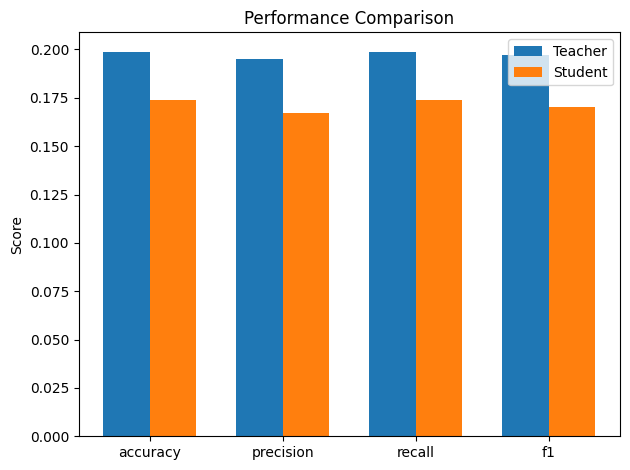

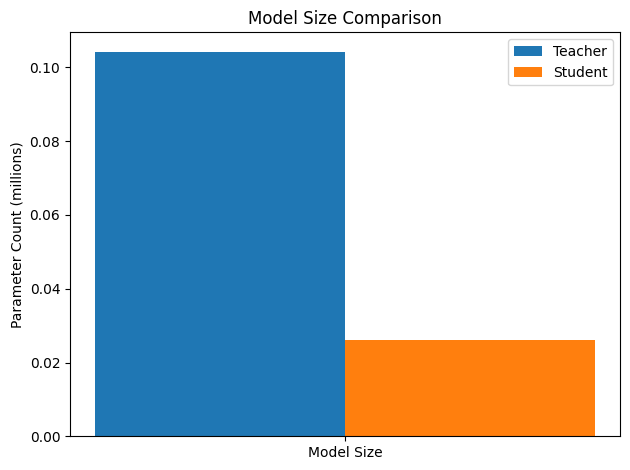

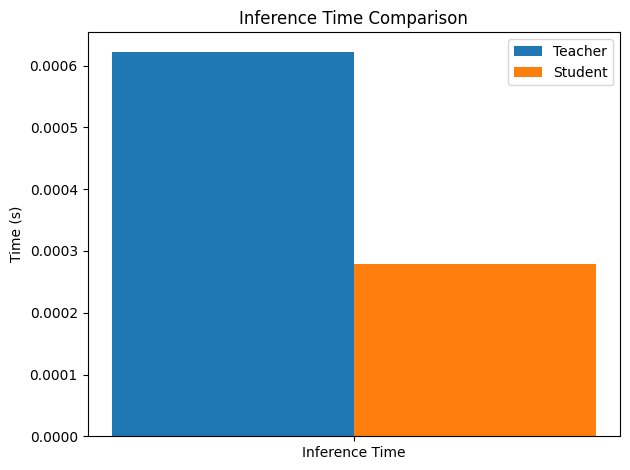

In [5]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

In [6]:
teacher_performance_values

[0.1988999992609024,
 0.1949247121810913,
 0.1988999992609024,
 0.19689230620861053]

In [7]:
performance_metrics

{'accuracy': (0.1988999992609024, 0.17362000048160553),
 'precision': (0.1949247121810913, 0.16708685457706451),
 'recall': (0.1988999992609024, 0.17362000048160553),
 'f1': (0.19689230620861053, 0.1702907830476761)}